<a href="https://colab.research.google.com/github/rishikaul22/Data-Science-Lab/blob/main/DS_exp3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 3

**Name:** Rishi Kaul

**UID:** 2018130019

**Outcomes:**
1. Apply Naive bayes classifier for given data see Naive_bayes_handout.zip file in edmodo.

2. Apply and compare Linear Discriminating Analysis with Naive bayes classifiers w.r.t. error, specificity and sensitivity

In [ ]:
#Basic libraries
import pandas as pd 
import numpy as np 


#NLTK libraries
import nltk
import re
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning libraries
import sklearn 
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn import preprocessing 


#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Other miscellaneous libraries
from scipy import interp
from itertools import cycle
import cufflinks as cf
from collections import defaultdict
from collections import Counter
from imblearn.over_sampling import SMOTE

## Importing the dataset


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Upon inspection, The dataset does not contain missing values apart from the reviewer name and reviewer text column

In [ ]:
data = pd.read_csv('/gdrive/My Drive/Datasets/Amazon Reviews/reviews.csv')
## print shape of dataset with rows and columns and information 
print("The shape of the  data is (row, column):"+ str(data.shape))
print(data.info())

The shape of the  data is (row, column):(10261, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB
None


In [ ]:
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


## Dataset Details
**This file has reviewer ID , User ID, Reviewer Name, Reviewer text, helpful, Summary(obtained from Reviewer text),Overall Rating on a scale 5, Review time**

**Description of columns in the file:**

* reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
* asin - ID of the product, e.g. 0000013714
* reviewerName - name of the reviewer
* helpful - helpfulness rating of the review, e.g. 2/3
* reviewText - text of the review
* overall - rating of the product
* summary - summary of the review
* unixReviewTime - time of the review (unix time)
* reviewTime - time of the review (raw)

<a id="section-two"></a>
# Preprocessing and cleaning


## Handling NaN values

**Checking for null values**

In [ ]:
#Creating a copy
processed_data=data.copy()

#Checking for null values
processed_data.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

**There are null values in reviewer names and review text. Reviewer names doesn't add any value(id's instead) to our objective of the project. So hence dropping the column makes sense. For review text, Dropping would not be a problem as there are only 7 null values but in this case i decided to fill the column with "missing" text as that too wouldn't have a significant effect**

In [ ]:
processed_data['reviewText'] = processed_data['reviewText'].fillna('Missing')

## Concatenating review text and summary
I am combining the review text and summary as the sentiments won't be contradicting in nature. 

In [ ]:
processed_data['reviews'] = processed_data['reviewText'] + processed_data['summary']

# dropping review text and summary
processed_data = processed_data.drop(['reviewText', 'summary'], axis=1)

processed_data.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1393545600,"02 28, 2014","Not much to write about here, but it does exac..."
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1363392000,"03 16, 2013",The product does exactly as it should and is q...
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5.0,1377648000,"08 28, 2013",The primary job of this device is to block the...
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5.0,1392336000,"02 14, 2014",Nice windscreen protects my MXL mic and preven...
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5.0,1392940800,"02 21, 2014",This pop filter is great. It looks and perform...


## Creating 'sentiment' column
**Here I am deciding the outcome column (sentiment of review) based on the overall score. If the score is greater than 3, I have taken that as positive and if the value is less than 3 it is negative If it is equal to 3, I've taken that as neutral sentiment**

In [ ]:
#Figuring out the distribution of categories
processed_data['overall'].value_counts()

5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64

In [ ]:
def f(row):
    
    '''This function returns sentiment value based on the overall ratings from the user'''
    
    if row['overall'] == 3.0:
        val = 'Neutral'
    elif row['overall'] == 1.0 or row['overall'] == 2.0:
        val = 'Negative'
    elif row['overall'] == 4.0 or row['overall'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [ ]:
#Applying the function in our new column
processed_data['sentiment'] = processed_data.apply(f, axis=1)
processed_data.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews,sentiment
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1393545600,"02 28, 2014","Not much to write about here, but it does exac...",Positive
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1363392000,"03 16, 2013",The product does exactly as it should and is q...,Positive
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5.0,1377648000,"08 28, 2013",The primary job of this device is to block the...,Positive
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5.0,1392336000,"02 14, 2014",Nice windscreen protects my MXL mic and preven...,Positive
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5.0,1392940800,"02 21, 2014",This pop filter is great. It looks and perform...,Positive


In [ ]:
processed_data['sentiment'].value_counts()

Positive    9022
Neutral      772
Negative     467
Name: sentiment, dtype: int64

## Handling time column

**Here we have a review time column which has date and year, once we split both we will split the date further into month and date.**

In [ ]:
# new data frame which has date and year
new = processed_data["reviewTime"].str.split(",", n = 1, expand = True) 
  
# making separate date column from new data frame 
processed_data["date"]= new[0] 
  
# making separate year column from new data frame 
processed_data["year"]= new[1] 

processed_data=processed_data.drop(['reviewTime'], axis=1)
processed_data.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviews,sentiment,date,year
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1393545600,"Not much to write about here, but it does exac...",Positive,02 28,2014
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1363392000,The product does exactly as it should and is q...,Positive,03 16,2013
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5.0,1377648000,The primary job of this device is to block the...,Positive,08 28,2013
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5.0,1392336000,Nice windscreen protects my MXL mic and preven...,Positive,02 14,2014
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5.0,1392940800,This pop filter is great. It looks and perform...,Positive,02 21,2014


In [ ]:
# Splitting the date 
new1 = processed_data["date"].str.split(" ", n = 1, expand = True) 
  
# adding month to the main dataset 
processed_data["month"]= new1[0] 
  
# adding day to the main dataset 
processed_data["day"]= new1[1] 

processed_data=processed_data.drop(['date'], axis=1)
processed_data.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviews,sentiment,year,month,day
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1393545600,"Not much to write about here, but it does exac...",Positive,2014,02,28
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1363392000,The product does exactly as it should and is q...,Positive,2013,03,16
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5.0,1377648000,The primary job of this device is to block the...,Positive,2013,08,28
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5.0,1392336000,Nice windscreen protects my MXL mic and preven...,Positive,2014,02,14
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5.0,1392940800,This pop filter is great. It looks and perform...,Positive,2014,02,21


## Review text-Punctuation Cleaning
**Let's begin our text processing by removing the punctuations**

In [ ]:
#Removing unnecessary columns
processed_data=processed_data.drop(['reviewerName','unixReviewTime'], axis=1)
#Creating a copy 
clean_reviews=processed_data.copy()

In [ ]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
processed_data['reviews']=processed_data['reviews'].apply(lambda x:review_cleaning(x))
processed_data.head()

,reviewerID,asin,helpful,overall,reviews,sentiment,year,month,day
0,A2IBPI20UZIR0U,1384719342,"[0, 0]",5.0,not much to write about here but it does exact...,Positive,2014,02,28
1,A14VAT5EAX3D9S,1384719342,"[13, 14]",5.0,the product does exactly as it should and is q...,Positive,2013,03,16
2,A195EZSQDW3E21,1384719342,"[1, 1]",5.0,the primary job of this device is to block the...,Positive,2013,08,28
3,A2C00NNG1ZQQG2,1384719342,"[0, 0]",5.0,nice windscreen protects my mxl mic and preven...,Positive,2014,02,14
4,A94QU4C90B1AX,1384719342,"[0, 0]",5.0,this pop filter is great it looks and performs...,Positive,2014,02,21


**I have removed all punctuation in the review column**

## Review text-Stop words
**Coming to stop words, general nltk stop words contains words like not,hasn't,would'nt which actually conveys a negative sentiment. If we remove that it will end up contradicting the target variable(sentiment). So I have curated the stop words which doesn't have any negative sentiment or any negative alternatives.**

In [ ]:
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't", 
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [ ]:
processed_data['reviews'] = processed_data['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
processed_data.head()

,reviewerID,asin,helpful,overall,reviews,sentiment,year,month,day
0,A2IBPI20UZIR0U,1384719342,"[0, 0]",5.0,not much write but exactly supposed filters po...,Positive,2014,02,28
1,A14VAT5EAX3D9S,1384719342,"[13, 14]",5.0,product exactly quite affordablei not realized...,Positive,2013,03,16
2,A195EZSQDW3E21,1384719342,"[1, 1]",5.0,primary job device block breath would otherwis...,Positive,2013,08,28
3,A2C00NNG1ZQQG2,1384719342,"[0, 0]",5.0,nice windscreen protects mxl mic prevents pops...,Positive,2014,02,14
4,A94QU4C90B1AX,1384719342,"[0, 0]",5.0,pop filter great looks performs like studio fi...,Positive,2014,02,21


I have removed all the stop words in the review column

## Year vs Sentiment count
**In this block we will see how many reviews were posted based on sentiments in each year from 2004 to 2014**

<Figure size 720x1080 with 0 Axes>

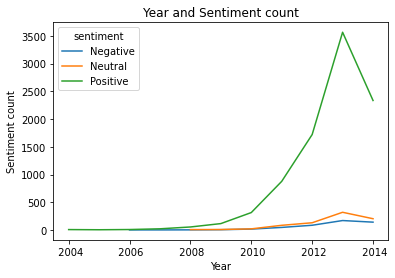

In [ ]:
plt.figure(figsize=(10,15))
processed_data.groupby(['year','sentiment'])['sentiment'].count().unstack().plot(legend=True)

plt.title('Year and Sentiment count')
plt.xlabel('Year')
plt.ylabel('Sentiment count')
plt.show()

**Insights:** <br>
**From the plot we can clearly see the rise in positive reviews from 2010. Reaching its peak around 2013 and there is a dip in 2014, All the review rates were dropped at this time. Negative and neutral reviews are very low as compared to the positive reviews. This also shows the psycological fear that people have before selling a product is simply a fear in their minds.**

## Day of month vs Reviews count
**Let's check if there are any relationship between reviews and day of month**

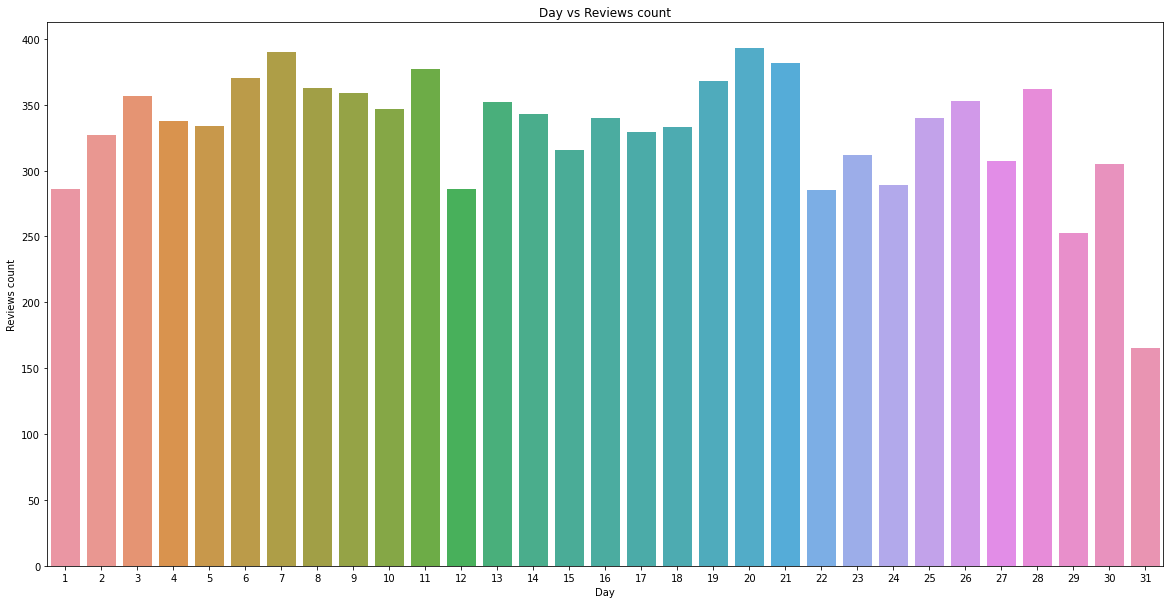

In [ ]:
#Creating a dataframe
day=pd.DataFrame(processed_data.groupby('day')['reviews'].count()).reset_index()
day['day']=day['day'].astype('int64')
day.sort_values(by=['day'])

#Plotting the graph
plt.figure(figsize=(20,10))
sns.barplot(x="day", y="reviews", data=day)
plt.title('Day vs Reviews count')
plt.xlabel('Day')
plt.ylabel('Reviews count')
plt.show()

**Insights:** <br>
**The review counts are more or less uniformly distributed.There isn't much variance between the days. But there is a huge drop at the end of month.**

## Creating few more features for text analysis
**Creating polarity, review length and word count**

**Polarity:** **I've used Textblob for figuring out the rate of sentiment . It is between [-1,1] where -1 is negative and 1 is positive polarity**

**Review length:** **length of the review which includes each letters and spaces**

**Word length:** **This measures how many words are there in review**

In [ ]:
processed_data['polarity'] = processed_data['reviews'].map(lambda text: TextBlob(text).sentiment.polarity)
processed_data['review_len'] = processed_data['reviews'].astype(str).apply(len)
processed_data['word_count'] = processed_data['reviews'].apply(lambda x: len(str(x).split()))

In [ ]:
processed_data.head()

,reviewerID,asin,helpful,overall,reviews,sentiment,year,month,day,polarity,review_len,word_count
0,A2IBPI20UZIR0U,1384719342,"[0, 0]",5.0,not much write but exactly supposed filters po...,Positive,2014,02,28,0.250000,162,25
1,A14VAT5EAX3D9S,1384719342,"[13, 14]",5.0,product exactly quite affordablei not realized...,Positive,2013,03,16,0.014286,356,55
2,A195EZSQDW3E21,1384719342,"[1, 1]",5.0,primary job device block breath would otherwis...,Positive,2013,08,28,0.167500,315,48
3,A2C00NNG1ZQQG2,1384719342,"[0, 0]",5.0,nice windscreen protects mxl mic prevents pops...,Positive,2014,02,14,0.333333,169,22
4,A94QU4C90B1AX,1384719342,"[0, 0]",5.0,pop filter great looks performs like studio fi...,Positive,2014,02,21,0.800000,136,21


<a id="section-four"></a>
# Extracting Features from Cleaned reviews
**Before I build the model for sentiment analysis, it is required to convert the review texts into vector formation as computer cannot understand words and their sentiment. I have used TF-TDF method to convert the texts**

## Encoding target variable-sentiment
**Let's encode our target variable with Label encoder.**

In [ ]:
# calling the label encoder function
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'sentiment'. 
processed_data['sentiment']= label_encoder.fit_transform(processed_data['sentiment']) 
  
processed_data['sentiment'].unique() 

array([2, 1, 0])

In [ ]:
processed_data['sentiment'].value_counts()

2    9022
1     772
0     467
Name: sentiment, dtype: int64

## Stemming the reviews
**Stemming is a method of deriving root word from the inflected word. Here we extract the reviews and convert the words in reviews to its root word. for example,**
* **Going->go**
* **Finally->fina**

**If you notice, the root words doesn't need to carry a semantic meaning. There is another technique knows as Lemmatization where it converts the words into root words which has a semantic meaning. Simce it takes time. I'm using stemming**

In [ ]:
#Extracting 'reviews' for processing
review_features=processed_data.copy()
review_features=review_features[['reviews']].reset_index(drop=True)
review_features.head()

,reviews
0,not much write but exactly supposed filters po...
1,product exactly quite affordablei not realized...
2,primary job device block breath would otherwis...
3,nice windscreen protects mxl mic prevents pops...
4,pop filter great looks performs like studio fi...


In [ ]:
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(review_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_features['reviews'][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)    

In [ ]:
corpus[3]

'nice windscreen protect mxl mic prevent pop thing gooseneck margin abl hold screen posit requir care posit clamp avoid sagginggood windscreen money'

**This is how a line looks like now, as computer cannot understand words and their sentiment we need to convert these words into 1's and 0's. To encode it we use TFIDF**

## TFIDF(Term Frequency — Inverse Document Frequency)
**TF-IDF stands for “Term Frequency — Inverse Document Frequency”. This is a technique to quantify a word in documents.**

**Here I am splitting as bigram (two words) and consider their combined weight.Also I am taking only the top 5000 words from the reviews.**

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(review_features['reviews'])

In [ ]:
X.shape

(10261, 5000)

**As I have considered 5000 words, I can confirm that we have 5000 columns from the shape.**

In [ ]:
#Getting the target variable(encoded)
y=processed_data['sentiment']

## Handling Imbalance target feature-SMOTE
**In the target feature, I noticed that we got a lot of positive sentiments compared to negative and neutral. So it is crucial to balance the classes in such a situation. Here I've used SMOTE(Synthetic Minority Oversampling Technique) to balance out the imbalanced dataset problem. It aims to balance class distribution by randomly increasing minority class examples by replicating them.** <br>

In [ ]:
print(f'Original dataset shape : {Counter(y)}')

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({2: 9022, 1: 772, 0: 467})
Resampled dataset shape Counter({2: 9022, 1: 9022, 0: 9022})


Now the resampled data has equally distributed classes

## Train-test split(75:25)
**Using train test split function I am splitting the dataset into 75:25 ratio for train and test set respectively.**

In [ ]:
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=0)

<a id="section-five"></a>
# Model Building: Sentiment Analysis
**After preprocessing, I have applied the Naive Bayes model from sklearn**

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Model building

**First select the best peforming model by using cross validaton. Let's consider all the classification algorithm and perform the model selection process**

In [ ]:
#creating the model
nb=GaussianNB()
nb.fit(X_train.toarray(),y_train)

y_pred = nb.predict(X_test.toarray())
print(accuracy_score(y_test, y_pred))


0.8801536870104921


**The model gave 88% accuracy. Now checking f1 score**

## Classification metrics
**Here we plot the confusion matrix with ROC and check our f1 score**

Confusion matrix, without normalization


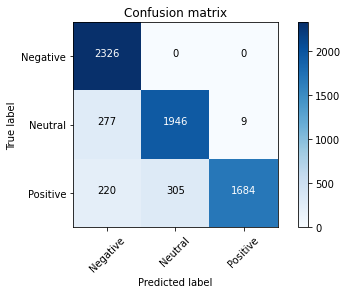

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'])

**Check out the diagonal elements(2326+1946+1684), they are correctly predicted records and rest are incorrectly classified by the algorithm**

In [ ]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90      2326
           1       0.86      0.87      0.87      2232
           2       0.99      0.76      0.86      2209

    accuracy                           0.88      6767
   macro avg       0.89      0.88      0.88      6767
weighted avg       0.89      0.88      0.88      6767



# Conclusion
**Through this experiment, I have classified all the classes starting from splitting the sentiments based on overall score,text cleaning, customize the stopwords list based on requirement and finally handling imbalance with smote. Here are few insights.**

* **Most of the neutral reviews were actual critic of product from the buyers, so amazon can consider these as feedback and give them to the seller to help them improve their products**
* **Most of the reviews in this dataset were about string instruments such as guitar.**
* **Balancing the dataset got me a very fruitful accuracy score. Without balancing, I could have got a good precision but very bad recall and inturn affected my f1 score. So balancing the target feature was important**
* **In sentiment analysis, we should concentrate on the f1 score where we got an average of 88%.**
